In [1]:
import pandas as pd 
import numpy as np
import math
import tensorflow as tf
print(pd.__version__)
import matplotlib.pyplot as plt
import progressbar
import scipy

1.2.0


## Print Dependencies



Dependences are fundamental to record the computational environment.

In [2]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p pandas,keras,numpy,math,tensorflow,matplotlib,h5py,progressbar,scipy

# date
print (" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.19.0

pandas     : 1.2.0
keras      : 2.4.3
numpy      : 1.19.5
math       : unknown
tensorflow : 2.4.0
matplotlib : 3.3.3
h5py       : 2.10.0
progressbar: 2.5
scipy      : 1.6.0

Compiler    : GCC 5.4.0 20160609
OS          : Linux
Release     : 5.8.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

 
Last updated: Tue Feb 02 2021 18:21:47CET



## Load of the data

In [3]:
from process import loaddata
regr_data = loaddata("../data/regression/250.csv")
class_data = loaddata("../data/classifier/250.csv")

In [4]:
np.random.shuffle(regr_data)
y = regr_data[:,-3:]
x = regr_data[:,:6]

In [5]:
np.random.shuffle(class_data)
yc = class_data[:,0]
xc = class_data[:,1:]

In [6]:
train_split = 0.75
train_limit = int(len(y)*train_split)
print("Training sample: {0} \nValuation sample: {1}".format(train_limit, len(y)-train_limit))

Training sample: 125414 
Valuation sample: 41805


In [7]:
x_train = x[:train_limit]
x_val = x[train_limit:]

y_train = y[:train_limit]
y_val = y[train_limit:]

## Model Build

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras import regularizers

## !! 
The dropout 0.2 seems to work better

In [9]:
def build_model() :
    model = models.Sequential()
    model.add (layers.Dense (12, kernel_initializer= "normal" , input_shape = x.shape))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (64, activation = "relu"))
    model.add (layers.Dense (128, activation = "relu"))
    model.add (layers.Dense (128, activation = "relu"))
    model.add (layers.Dense (64, activation = "relu"))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (12, activation = "relu"))
    model.add (layers.Dense (3))
    model.compile(optimizer = "rmsprop" , loss = "mse" , metrics =["mape"])
    return model

In [10]:
model = build_model ()
history = model.fit ( x_train, y_train, epochs = 20, batch_size = 50, validation_data = (x_val, y_val) )
model.save("../models/regression/large_mse250.h5")

Epoch 1/20
2509/2509 [==============================] - 8s 2ms/step - loss: 3.6260e-04 - mape: 188.4719 - val_loss: 3.2385e-05 - val_mape: 114.1778
Epoch 2/20
2509/2509 [==============================] - 6s 2ms/step - loss: 2.5370e-05 - mape: 77.7694 - val_loss: 1.2159e-05 - val_mape: 58.1227
Epoch 3/20
2509/2509 [==============================] - 6s 3ms/step - loss: 1.7074e-05 - mape: 67.1525 - val_loss: 1.4053e-05 - val_mape: 63.8861
Epoch 4/20
2509/2509 [==============================] - 7s 3ms/step - loss: 1.3409e-05 - mape: 57.1771 - val_loss: 5.9645e-06 - val_mape: 32.6862
Epoch 5/20
2509/2509 [==============================] - 6s 2ms/step - loss: 1.1301e-05 - mape: 52.6016 - val_loss: 1.2020e-05 - val_mape: 57.6500
Epoch 6/20
2509/2509 [==============================] - 6s 2ms/step - loss: 9.9644e-06 - mape: 53.9293 - val_loss: 4.3288e-06 - val_mape: 33.4636
Epoch 7/20
2509/2509 [==============================] - 8s 3ms/step - loss: 8.9061e-06 - mape: 44.9946 - val_loss: 1.4909e

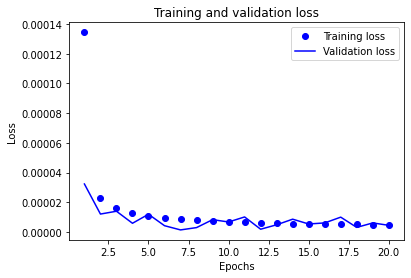

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test spectrum

In [12]:
from tensorflow import keras
model_regr = keras.models.load_model('../models/regression/large_mse250.h5')
model_class = keras.models.load_model('../models/classifier/with-dropout-250.h5')

In [13]:
model_regr.summary()
model_class.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 167219, 12)        84        
_________________________________________________________________
dense_1 (Dense)              (None, 167219, 32)        416       
_________________________________________________________________
dense_2 (Dense)              (None, 167219, 64)        2112      
_________________________________________________________________
dense_3 (Dense)              (None, 167219, 128)       8320      
_________________________________________________________________
dense_4 (Dense)              (None, 167219, 128)       16512     
_________________________________________________________________
dense_5 (Dense)              (None, 167219, 64)        8256      
_________________________________________________________________
dense_6 (Dense)              (None, 167219, 32)        2

In [14]:
def energy_spectrum(energy_array, bins):
    energy_array = np.array(energy_array)
    plt.hist(energy_array, bins, histtype=u'step', density=True)
    plt.yscale("log")
    plt.show()

In [15]:
final_p = []
final_e = []

for regr_pair in regr_data:
    final_e.append(np.linalg.norm(regr_pair[10:13]))
    final_p.append(np.linalg.norm(regr_pair[13:16]))

In [18]:
y = []
pred = []

y = model_class.predict(xc)
data = np.hstack((y, xc))
data = data[np.logical_not(data[:,0] > 0.5)]
pred = model_regr.predict(data[:,1:7])

In [19]:
final_p_nn = []
for pred_ in pred:
    final_p_nn.append(np.linalg.norm(pred_))

In [ ]:
energy_spectrum(photon_final_nn, 75)

In [22]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chisquare

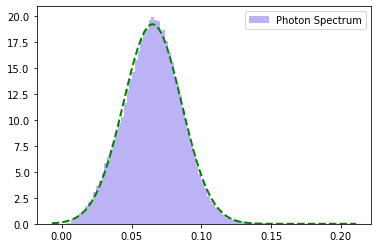

In [23]:
mean,std=norm.fit(final_p)
plt.hist(final_p, bins=100, alpha = 0.5, color = 'mediumslateblue', label='Photon Spectrum', density = True)
plt.legend(loc='upper right')
xmin, xmax = plt.xlim()
x_p = np.linspace(xmin, xmax, 100)
y_p = norm.pdf(x_p, mean, std)
plt.plot(x_p, y_p,'g--', linewidth=2)
plt.show()

In [24]:
print('mean = ', mean)
print('std = ', std)
print("chi square = ", stats.chisquare(final_p))

mean =  0.06500765839861218
std =  0.02078036262467183
chi square =  Power_divergenceResult(statistic=1110.7781874419406, pvalue=1.0)


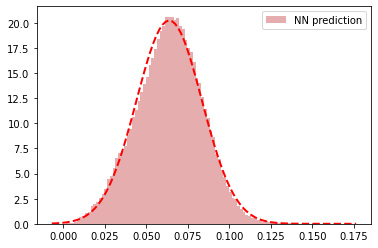

In [27]:
mean_nn,std_nn=norm.fit(final_p_nn)
plt.hist(final_p_nn, bins=100, alpha = 0.5,  color = 'indianred', label='NN prediction', density = True)
xmin, xmax = plt.xlim()
x_nn = np.linspace(xmin, xmax, 100)
y_nn = norm.pdf(x_nn, mean_nn, std_nn)
plt.plot(x_nn, y_nn,'r--', linewidth=2)
plt.legend(loc='upper right')
plt.show()

In [28]:
print('mean = ', mean)
print('std = ', std)
print("chi square = ", stats.chisquare(final_p_nn))

mean =  0.06500765839861218
std =  0.02078036262467183
chi square =  Power_divergenceResult(statistic=1113.1231949724722, pvalue=1.0)


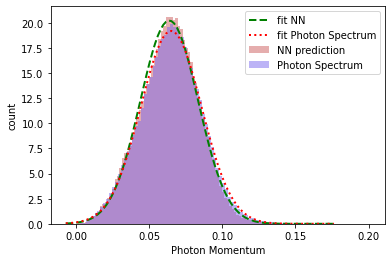

In [29]:
plt.hist(final_p_nn, 100, alpha=0.5, color = 'indianred', label='NN prediction', density = True)
plt.hist(final_p, 100, alpha=0.5, color = 'mediumslateblue', label='Photon Spectrum', density = True)
plt.xlabel('Photon Momentum')
plt.ylabel('count')
plt.legend(loc='upper right')
x_nn = np.linspace(xmin, xmax, 100)
y_nn = norm.pdf(x_nn, mean_nn, std_nn)
plt.plot(x_nn, y_nn,'g--', label = 'fit NN', linewidth = 2)
plt.legend(loc='upper right')
x_p = np.linspace(xmin, xmax, 100)
y_p = norm.pdf(x_p, mean, std)
plt.plot(x_p, y_p, 'r:', label = 'fit Photon Spectrum', linewidth = 2)
plt.legend(loc = 'upper right')
plt.show()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


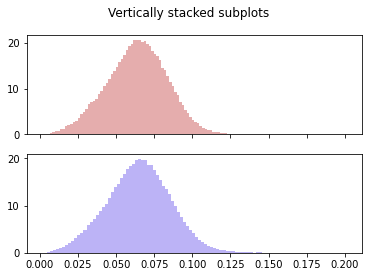

In [30]:
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('Vertically stacked subplots')
axs[0].hist(final_p_nn, 100, alpha=0.5, color = 'indianred', label='NN prediction', density = True)
axs[1].hist(final_p, 100, alpha=0.5, color = 'mediumslateblue', label='Photon Spectrum', density = True)
fig.show()